In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
from collections import Counter
from torch_geometric.datasets import Planetoid

In [2]:
def make_deterministic(random_seed=123):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    
make_deterministic()

In [3]:
dataset = Planetoid(root='PyGApply/data', name='Cora')

Processing...
Done!


In [4]:
def show_dataset_stats(dataset):
    print(f"Number of graphs: {len(dataset)}")
    print(f"Number of node classes: {dataset.num_classes}")
    print(f"Number of node features: {dataset.num_node_features}")
show_dataset_stats(dataset)

Number of graphs: 1
Number of node classes: 7
Number of node features: 1433


In [5]:
def show_graph_stats(graph):
    print(f"Number of nodes: {graph.x.shape[0]}")
    print(f"Number of node features: {graph.x.shape[1]}")
    print(f"Number of edges: {graph.edge_index.shape[1]}")

graph = dataset[0]
show_graph_stats(graph)

Number of nodes: 2708
Number of node features: 1433
Number of edges: 10556


In [6]:
graph.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [7]:
graph.edge_index.T

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

In [8]:
"""
Class Definition
0: Theory
1: Reinforcement_Learning
2: Genetic_Algorithms
3: Neural_Networks
4: Probabilistic_Methods
5: Case_Based
6: Rule_Learning
"""
sorted(Counter(graph.y.tolist()).items())

[(0, 351), (1, 217), (2, 418), (3, 818), (4, 426), (5, 298), (6, 180)]

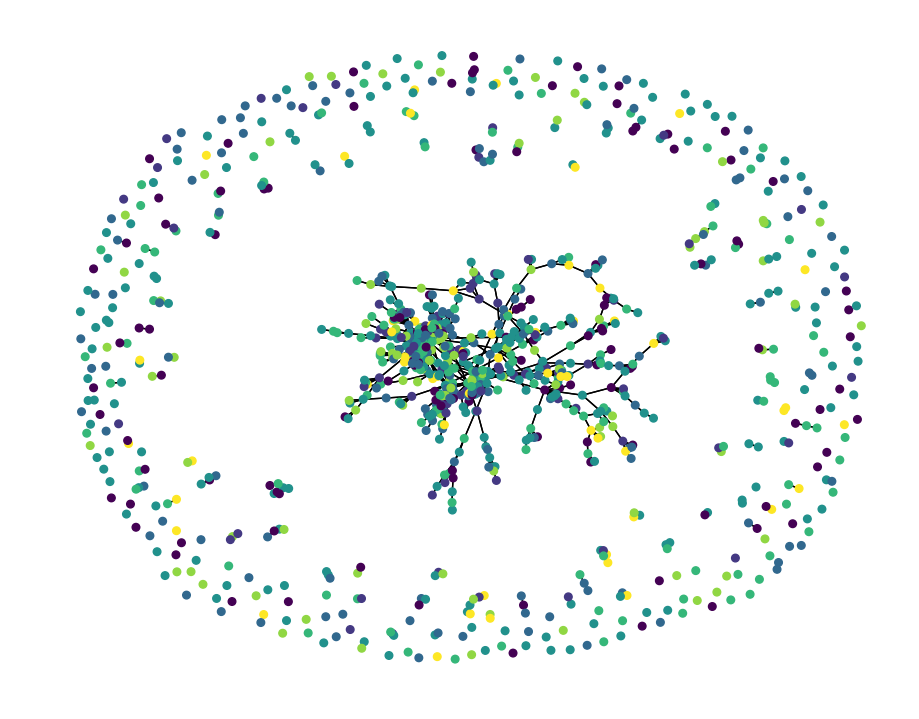

In [9]:
def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(list(g.nodes), n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 

g, y = convert_to_networkx(graph, n_sample=1000)
plot_graph(g, y)

In [10]:
split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(graph)  # resetting data split
print(
    f"train: {int(graph.train_mask.sum())}, ",
    f"val: {int(graph.val_mask.sum())}, ",
    f"test: {int(graph.test_mask.sum())}",
)

train: 1895,  val: 271,  test: 542


In [11]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(dataset.num_node_features, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, dataset.num_classes)
        )

    def forward(self, data):
        x = data.x  # only using node features (x)
        output = self.layers(x)
        return output

In [12]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, graph, graph.val_mask)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')

    return model


def eval_node_classifier(model, graph, mask):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())

    return acc

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph = graph.to(device)
mlp = MLP().to(device)
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

mlp = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs=150)

Epoch: 010, Train Loss: 0.770, Val Acc: 0.694
Epoch: 020, Train Loss: 0.089, Val Acc: 0.727
Epoch: 030, Train Loss: 0.018, Val Acc: 0.716
Epoch: 040, Train Loss: 0.012, Val Acc: 0.720
Epoch: 050, Train Loss: 0.015, Val Acc: 0.753
Epoch: 060, Train Loss: 0.013, Val Acc: 0.745
Epoch: 070, Train Loss: 0.011, Val Acc: 0.749
Epoch: 080, Train Loss: 0.010, Val Acc: 0.734
Epoch: 090, Train Loss: 0.009, Val Acc: 0.731
Epoch: 100, Train Loss: 0.009, Val Acc: 0.731
Epoch: 110, Train Loss: 0.008, Val Acc: 0.734
Epoch: 120, Train Loss: 0.008, Val Acc: 0.738
Epoch: 130, Train Loss: 0.008, Val Acc: 0.731
Epoch: 140, Train Loss: 0.007, Val Acc: 0.731
Epoch: 150, Train Loss: 0.007, Val Acc: 0.731


In [14]:
test_acc = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Test Acc: 0.731


In [15]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output

In [16]:
gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

Epoch: 010, Train Loss: 1.017, Val Acc: 0.790
Epoch: 020, Train Loss: 0.411, Val Acc: 0.889
Epoch: 030, Train Loss: 0.240, Val Acc: 0.897
Epoch: 040, Train Loss: 0.178, Val Acc: 0.900
Epoch: 050, Train Loss: 0.149, Val Acc: 0.889
Epoch: 060, Train Loss: 0.135, Val Acc: 0.893
Epoch: 070, Train Loss: 0.126, Val Acc: 0.886
Epoch: 080, Train Loss: 0.117, Val Acc: 0.886
Epoch: 090, Train Loss: 0.110, Val Acc: 0.886
Epoch: 100, Train Loss: 0.103, Val Acc: 0.886
Epoch: 110, Train Loss: 0.097, Val Acc: 0.882
Epoch: 120, Train Loss: 0.092, Val Acc: 0.882
Epoch: 130, Train Loss: 0.088, Val Acc: 0.878
Epoch: 140, Train Loss: 0.085, Val Acc: 0.875
Epoch: 150, Train Loss: 0.081, Val Acc: 0.875
Epoch: 160, Train Loss: 0.079, Val Acc: 0.875
Epoch: 170, Train Loss: 0.076, Val Acc: 0.878
Epoch: 180, Train Loss: 0.074, Val Acc: 0.878
Epoch: 190, Train Loss: 0.072, Val Acc: 0.878
Epoch: 200, Train Loss: 0.070, Val Acc: 0.878


In [17]:
test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Test Acc: 0.878


yellow node: correct 
purple node: wrong


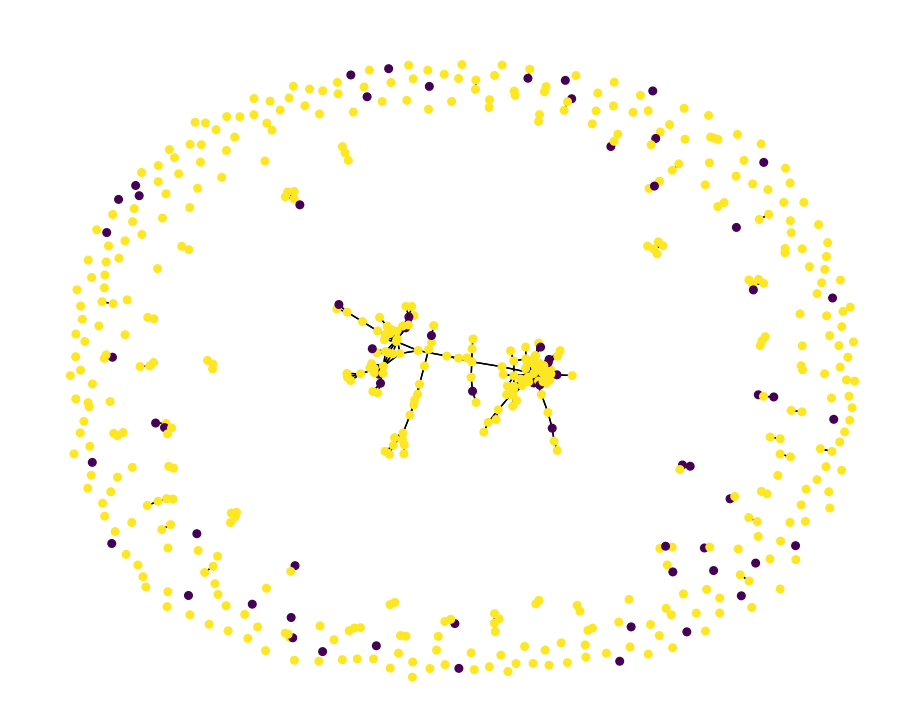

In [18]:
#GPU不能将tensor转换为numpy，转到cpu上面再转换
def visualize_classification_result(model, graph):

    model.eval()
    pred = model(graph).argmax(dim=1)
    corrects = (pred[graph.test_mask] == graph.y[graph.test_mask])
    corrects = corrects.cpu().numpy().astype(int)
    test_index = np.arange(len(graph.x))[graph.test_mask.cpu().numpy()]
    g, y = convert_to_networkx(graph.cpu())
    g_test = g.subgraph(test_index)

    print("yellow node: correct \npurple node: wrong")
    plot_graph(g_test, corrects)

visualize_classification_result(gcn, graph)

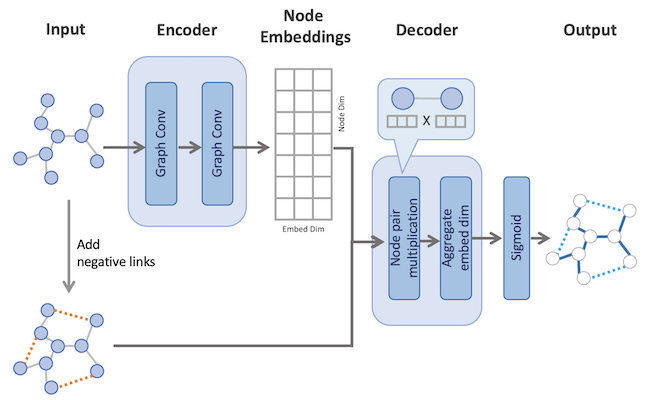

In [19]:
%matplotlib inline
from IPython.display import Image
Image(filename=r'D:\pycharm project\GNN\PyGApply\PyGApply\下载.png')

In [20]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(
            dim=-1
        )  # product of a pair of nodes on each edge

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [21]:
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


def train_link_predictor(
    model, train_data, val_data, optimizer, criterion, n_epochs=100
):

    for epoch in range(1, n_epochs + 1):

        model.train()
        optimizer.zero_grad()
        z = model.encode(train_data.x, train_data.edge_index)

        # sampling training negatives for every training epoch
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        val_auc = eval_link_predictor(model, val_data)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

    return model


@torch.no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [22]:
""" deleting node split masks """

del graph.train_mask 
del graph.val_mask 
del graph.test_mask

split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)
train_data, val_data, test_data = split(graph)

print('train_data:', train_data)
print('val_data:', val_data)
print('test_data:', test_data)

train_data: Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], edge_label=[4488], edge_label_index=[2, 4488])
val_data: Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], edge_label=[526], edge_label_index=[2, 526])
test_data: Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], edge_label=[1054], edge_label_index=[2, 1054])
